# Train AE with data generated on MullerBrown potential 

In [2]:
from IPython.core.display import  HTML
# Jupyter display settings
display(HTML("<style>.container { width:90% !important; }</style>"))

General imports 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from potentials.MullerBrown import MullerBrown
from simulations.UnbiasedMD import OverdampedLangevin

Generate dataset 

In [5]:
pot = MullerBrown()

In [9]:
beta = 0.5
dt = 0.0001
unbiased_OL_on_MB = OverdampedLangevin(pot, beta, dt=dt)
x_0 = pot.minP
n_steps = 2 * 10**4

In [8]:
traj_dict1 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [10]:
x_0 = pot.minR
traj_dict2 = unbiased_OL_on_MB.run(x_0, n_steps, save_grad=False, save_gauss=False)

In [11]:
trajs = np.append(traj_dict1["x_traj"], traj_dict2["x_traj"], axis=0)
#trajs = trajs[np.random.choice(len(trajs), size=2 * 10**4)]
#np.savetxt('dataset_MB.txt', trajs)

In [12]:
## fix the random seed to subsample the dataset and for torch 
import torch 
import random
def set_all_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
seed = 0 
set_all_seeds(seed)

In [39]:
trajs = np.loadtxt('dataset_MB.txt')
trajs = trajs[np.random.choice(len(trajs), size=2 * 10**5)]
react_approx_density = np.loadtxt("mullerbrown_react_dens.txt")
react_approx_density = react_approx_density[np.random.choice(len(react_approx_density), size=2 * 10**5)]

'\nfig, (ax1) = plt.subplots(1, 1, figsize=(9, 6)) \npot.plot_potential_heat_map(ax1)\nax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color=\'purple\', label=\'Minimum energy path\')\nax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color=\'purple\')\nax1.scatter(react_approx_density[idx][:, 0], react_approx_density[idx][:, 1], marker=".", color="orange", s=1)\nax1.set_xlabel(r\'$x_1$\')\nax1.set_ylabel(r\'$x_2$\')\n#ax1.set_title("b) Reactive trajectories distribution")\nax1.legend()\nplt.savefig("bolz_vs_reac_on_heatmap_b.png", format="png", dpi=160)\n'

/work/pigeont/miniconda3/envs/pytorch/lib/python3.12/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


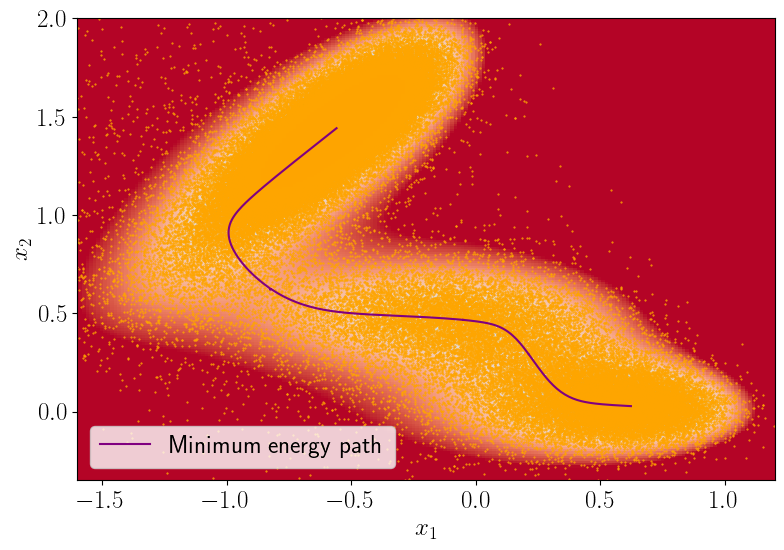

In [40]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 18})

#idx = [np.random.choice(len(trajs), size=2 * 10**4)]
pot.set_2D_plot_grid_precision(200, 200)
fig, (ax) = plt.subplots(1, 1, figsize=(9, 6)) 

pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax.scatter(trajs[:][:, 0], trajs[:][:, 1], marker=".", color="orange", s=1)
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.set_title("a) Bolzmann-Gibbs distribution")
ax.legend()
#plt.savefig("bolz_vs_reac_on_heatmap_a.png", format="png", dpi=160)

"""
fig, (ax1) = plt.subplots(1, 1, figsize=(9, 6)) 
pot.plot_potential_heat_map(ax1)
ax1.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax1.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ax1.scatter(react_approx_density[idx][:, 0], react_approx_density[idx][:, 1], marker=".", color="orange", s=1)
ax1.set_xlabel(r'$x_1$')
ax1.set_ylabel(r'$x_2$')
#ax1.set_title("b) Reactive trajectories distribution")
ax1.legend()
plt.savefig("bolz_vs_reac_on_heatmap_b.png", format="png", dpi=160)
"""

In [41]:
dataset = {"boltz_points": trajs}
#dataset = {"boltz_points": trajs, "react_points":react_approx_density}

In [42]:
dataset.keys()

dict_keys(['boltz_points'])

Import AE model 

In [43]:
from autoencoders.ae_models import DeepAutoEncoder
from autoencoders.ae_models import DeepAutoEncoderDoubleDec
from autoencoders.ae_models import DeepAutoEncoderMultipleDec
from autoencoders.train_aes import TrainAETwoDecoder
from autoencoders.train_aes import TrainAEOneDecoder
from autoencoders.train_aes import TrainAEMultipleDecoders

In [44]:
np.random.randint(10**5, size=20)

array([60501, 87522, 88419, 29855, 55729,  9842, 93174, 35683,  6581,
        3876, 53991, 41127, 94133, 17094, 36961, 19778,   973, 49843,
       23436, 74450])

Create autoencoder object

In [100]:
del(ae)
del(ae_training)

Fix the torch random seed

In [101]:
seed = 60501  ## Seed 6 leads to the "wrong solution" Seed 2 is really good: visually close to MEP , seed 10 figures paper
#set_all_seeds(seed)
#ae = DeepAutoEncoder([2, 5, 5, 1], [1, 20, 20, 2], 0)
#ae = DeepAutoEncoderDoubleDec([2, 5, 5, 1], [1, 20, 20, 2], 0)
ae = DeepAutoEncoderMultipleDec([2, 5, 5, 1], [1, 20, 20, 2], 0, 4)

Created training object

In [102]:
#ae_training = TrainAEOneDecoder(ae, pot, dataset.copy(), standardize=False, zca_whiten=False)
#ae_training = TrainAETwoDecoder(ae, pot, dataset.copy(), standardize=False, zca_whiten=False)
ae_training = TrainAEMultipleDecoders(ae, pot, dataset.copy(), standardize=False, zca_whiten=False)

Set the training size and do the train-test split

In [103]:
ae_training.train_test_split(train_size=2 * 10**4)
ae_training.split_training_dataset_K_folds(2)
ae_training.set_train_val_data(0)

Set the optimizer 

In [104]:
ae_training.set_optimizer('Adam', 0.005)

Set the loss function parameters 

In [105]:
loss_params = {}
loss_params["mse_boltz_weight"] = 1. * 10**(0)
loss_params["mse_react_weight"] = 0. * 10**(0)
loss_params["squared_grad_boltz_weight"] = 0. * 10**(-4)
loss_params["var_enc_weight"] = 0. * 10**(0)
loss_params["pen_points_weight"] = 0. * 10**(0)
loss_params["pen_points_mse_weight"] = 0. * 10**(0)

loss_params["n_wait"] = 50
ae_training.set_loss_weight(loss_params)

l1_pen_weight value not provided, set to default value of:  0
l2_pen_weight value not provided, set to default value of:  0
var_dist_dec_weight value not provided, set to default value of:  0.0
n_bins_var_dist_dec value not provided, set to default value of:  20


Set the max number of epoch and batch size 

In [106]:
batch_size = 5*10**2
max_epochs = 10000

Train 

In [107]:
loss_dict = ae_training.train(batch_size, max_epochs)

training ends after 1016 epochs.



Plot the evolution of the loss stating from the 100th epoch 

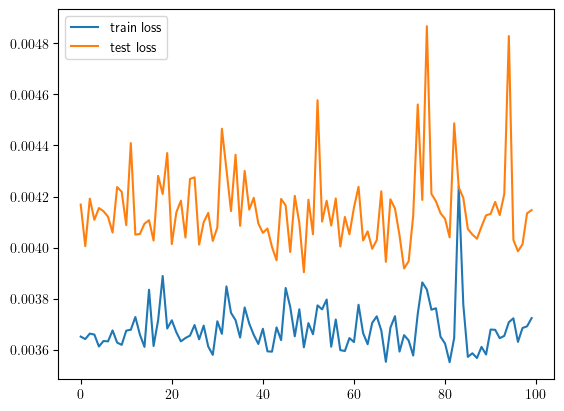

In [108]:
plt.figure()
plt.plot(loss_dict["train_loss"][-100:], label='train loss')
plt.plot(loss_dict["test_loss"][-100:], label='test loss')
plt.legend()

In [109]:
print(ae_training.ae.encoder(ae_training.test_dataset[:, :2]).min())
#print(ae_training.ae.encoder(ae_training.test_dataset[:, 3:5]).min())
print(ae_training.ae.encoder(ae_training.test_dataset[:, :2]).max())
#print(ae_training.ae.encoder(ae_training.test_dataset[:, 3:5]).max())

tensor(-1.3937, grad_fn=<MinBackward1>)
tensor(1.5205, grad_fn=<MaxBackward1>)


Plot the conditionnal averages on the potential heat map 

Text(0, 0.5, '$x_2$')

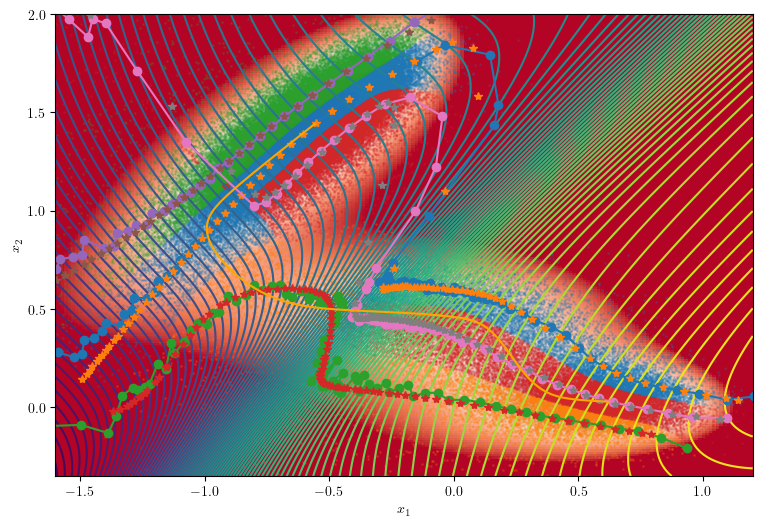

In [110]:
plt.rcParams.update({'font.size': 10})
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)

ae_training.plot_encoder_iso_levels(ax, 100)
z_bin, Esp_X_given_z_boltz, f_dec_z_boltz  = ae_training.plot_conditional_averages(ax, 100, with_react_dens=False, z_minmax=None)
#z_bin, Esp_X_given_z_boltz_dec1, Esp_X_given_z_boltz_dec2 = ae_training.plot_conditional_averages(ax, 100, with_react_dens=False, z_minmax=None)
#z_bin, Esp_X_given_z_reac_dec1, Esp_X_given_z_reac_dec1 = ae_training.plot_conditional_averages(ax, 100, with_react_dens=True, z_minmax=[-3.8, 2.5])
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
#ax.legend()
#plt.savefig("double_dec_mullerbrown.png", format='png', dpi=160)

In [1]:
#Esp_X_given_z_weighted = (loss_params["mse_boltz_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"])) * Esp_X_given_z_boltz + (loss_params["mse_react_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"]))  * Esp_X_given_z_reac
#f_dec_X_given_z_mean = ae_training.ae(torch.tensor(Esp_X_given_z_weighted.astype('float32'))).detach().numpy()

Esp_X_given_z_weighted_dec1 = (loss_params["mse_boltz_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"])) * Esp_X_given_z_boltz_dec1 + (loss_params["mse_react_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"]))  * Esp_X_given_z_reac_dec1
Esp_X_given_z_weighted_dec2 = (loss_params["mse_boltz_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"])) * Esp_X_given_z_boltz_dec2 + (loss_params["mse_react_weight"]/(loss_params["mse_boltz_weight"] + loss_params["mse_react_weight"]))  * Esp_X_given_z_reac_dec2

f_dec_X_given_z_mean_dec1 = ae_training.ae.decoder1(ae_training.ae.encoder(torch.tensor(Esp_X_given_z_weighted_dec1.astype('float32')))).detach().numpy()
f_dec_X_given_z_mean_dec2 = ae_training.ae.decoder2(ae_training.ae.encoder(torch.tensor(Esp_X_given_z_weighted_dec2.astype('float32')))).detach().numpy()

NameError: name 'loss_params' is not defined

In [ ]:
plt.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='purple', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='purple')
ae_training.plot_encoder_iso_levels(ax, 100)
#ax.plot(Esp_X_given_z_weighted[:, 0], Esp_X_given_z_weighted[:, 1], '-o', color='blue', label='cond. avg.')
ax.plot(f_dec_X_given_z_mean[:, 0], f_dec_X_given_z_mean[:, 1], '-*', color='black', label='decoder')
ax.set_xlabel(r'$x_1$')
ax.set_ylabel(r'$x_2$')
ax.legend()
#plt.savefig("MB_Mieux.png", format='png', dpi=160)

Plot convergence of the principal curve 

In [ ]:
fig1, (ax1) = plt.subplots(1, 1, figsize=(9, 6)) 
fig2, (ax2) = plt.subplots(1, 1, figsize=(9, 6)) 
ax1.set_xlabel(r'$z$')
ax1.set_ylabel(r'$\rho(z)$')
ax2.set_xlabel(r'$z$')
ax2.set_ylabel(r'$\Big\|f_{dec}(z) - \mathbf{E}[ x | f_{enc}(x) = z] \Big\|$')
ae_training.plot_principal_curve_convergence(ax1, ax2, 100, y_scale_cosine=[0.3, 1.05])
#fig1.savefig("cos_angle_enc_dec_b.png", format='png', dpi=160)
#fig2.savefig("dist_cdt_avg_dec_b.png", format='png', dpi=160)


In [ ]:
print(ae_training.ae.encoder(ae_training.test_dataset[:, :2]).max())
print(ae_training.ae.encoder(ae_training.test_dataset[:, 3:5]).max())

In [ ]:
np.mean([0.0154, 0.0155, 0.0157, 0.0154, 0.0156, 0.0157])

In [ ]:
boltz_points = torch.tensor(ae_training.dataset["boltz_points"].astype('float32'))
boltz_points_decoded1 = ae_training.ae.decoder1(ae_training.ae.encoder(boltz_points))
boltz_points_decoded2 = ae_training.ae.decoder2(ae_training.ae.encoder(boltz_points))
x1 = torch.sum((boltz_points - boltz_points_decoded1) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded2) ** 2,
            dim=1).detach().numpy()
x2 = torch.sum((boltz_points - boltz_points_decoded2) ** 2, dim=1).detach().numpy() < torch.sum(
            (boltz_points - boltz_points_decoded1) ** 2,
            dim=1).detach().numpy()

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot()
pot.plot_potential_heat_map(ax)
ax.scatter(ae_training.dataset["boltz_points"][x1][:, 0], ae_training.dataset["boltz_points"][x1][:, 1], color='blue', label='decoder1', s=1)
ax.scatter(ae_training.dataset["boltz_points"][x2][:, 0], ae_training.dataset["boltz_points"][x2][:, 1], color='purple', label='decoder2', s=1)
ax.plot(pot.minimum_energy_paths[0][:, 0], pot.minimum_energy_paths[0][:, 1], color='orange', label='Minimum energy path')
ax.plot(pot.minimum_energy_paths[1][:, 0], pot.minimum_energy_paths[1][:, 1], color='orange')
ae_training.plot_encoder_iso_levels(ax, 20)
ax.legend()